#### 참고) HSV
* 색깔을 각도로 표현.(0~180도)
* H: 색깔(0-180), S: 채도(높을수록 밝은 색상 0-255), , V: 밝기(높을수록 밝은 색상 0-255)
* ex)빨간색 0~10/170~180 까지 H를 가져온다.
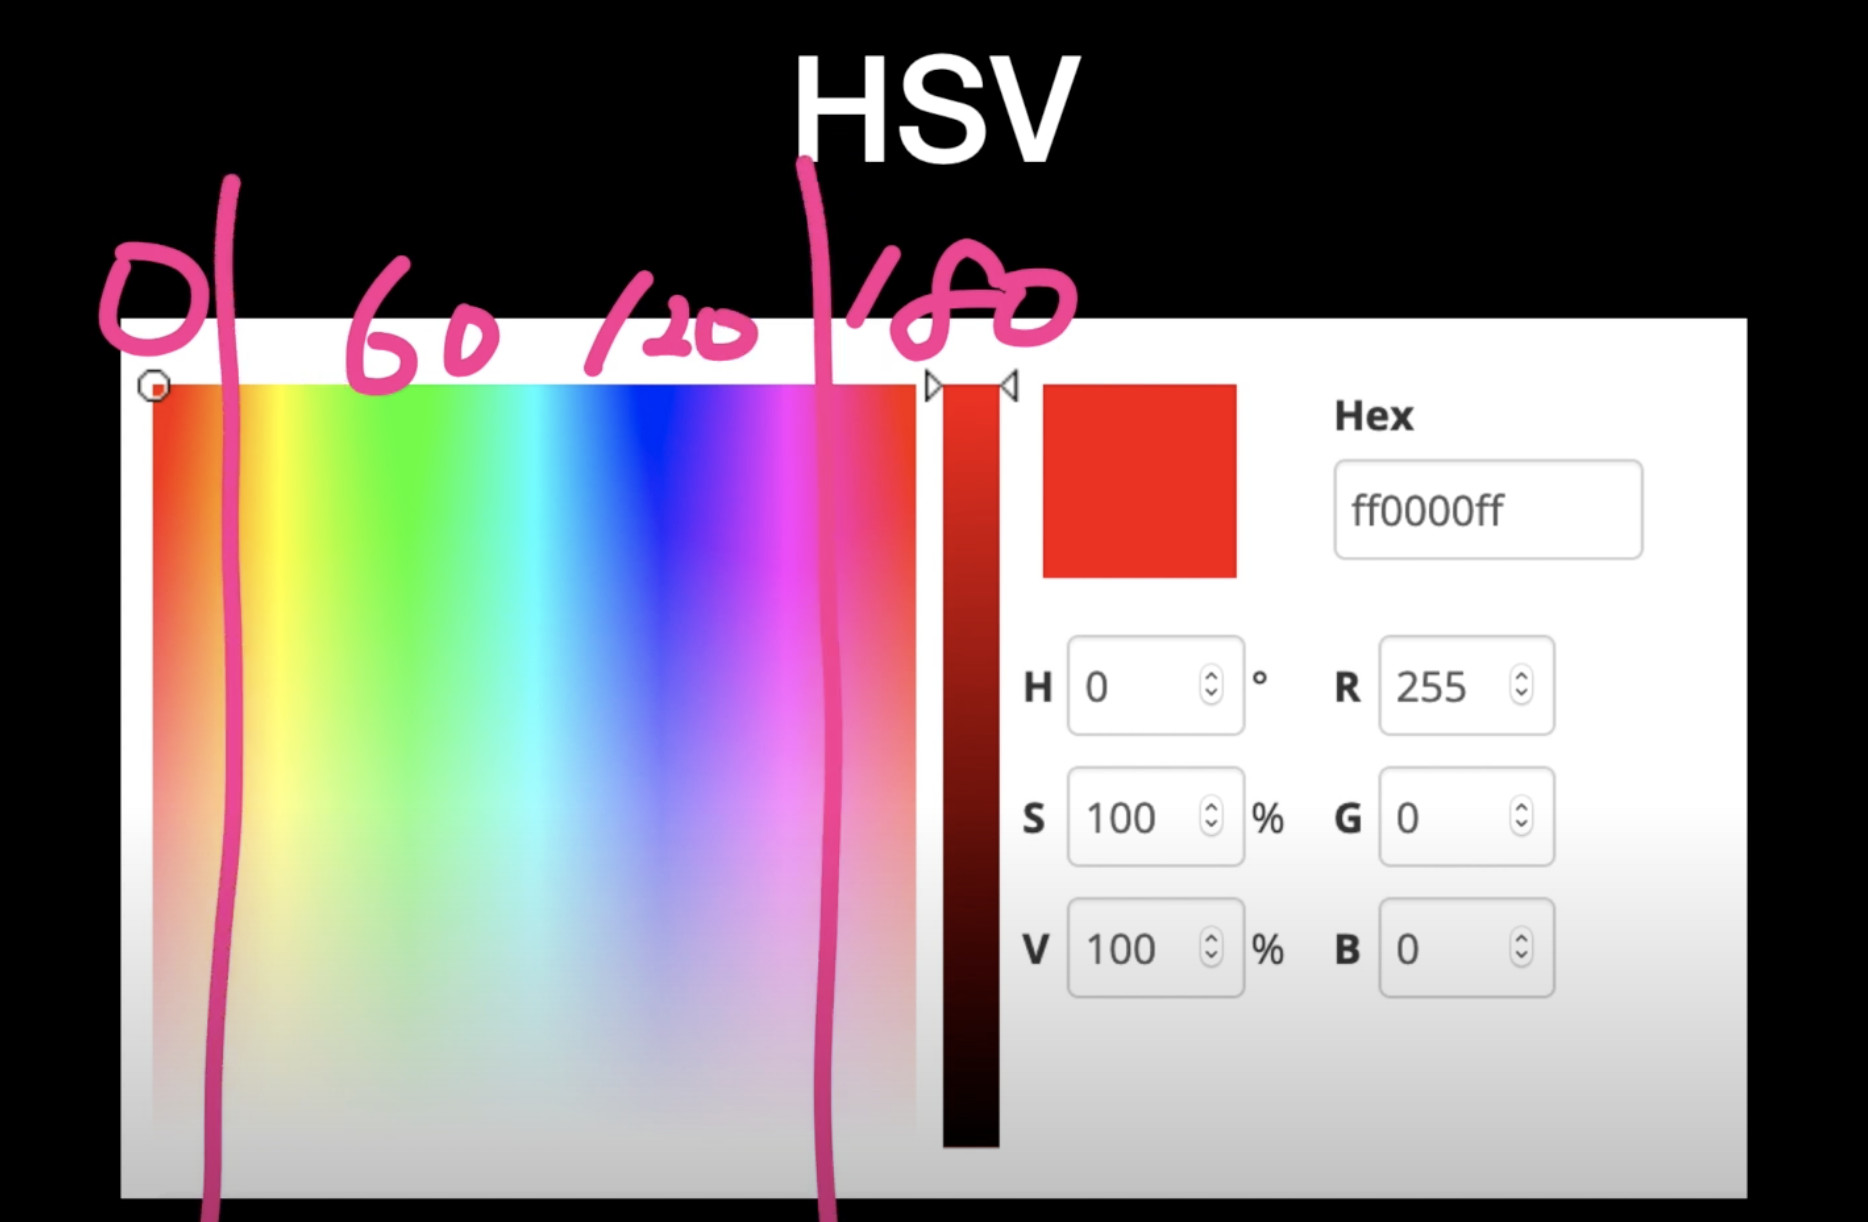

In [2]:
import cv2
import numpy as np
import time, argparse

In [18]:
is_video_file = None

cap = cv2.VideoCapture(is_video_file if is_video_file else 0)

time.sleep(3)   # 카메라 켜지길 기다려줌

# 사물, 사람이 없는 배경 이미지를 찍어야 함( 약 2초 )
# Grap background image from first part of the video
for i in range(60):
  ret, background = cap.read()

# 동영상 기록, 저장
fourcc = cv2.VideoWriter_fourcc('m', 'p', '4', 'v')
# fourcc = cv2.VideoWriter_fourcc(*'avc1')
# out = cv2.VideoWriter('videos/output.mp4', fourcc, cap.get(cv2.CAP_PROP_FPS), (background.shape[1], background.shape[0]))
# out2 = cv2.VideoWriter('videos/original.mp4', fourcc, cap.get(cv2.CAP_PROP_FPS), (background.shape[1], background.shape[0]))

print(cap.get(cv2.CAP_PROP_FPS))
print(cv2.CAP_PROP_FPS)

## FPS를 가져오는 코드가 에러가남(cap.get(cv2.CAP_PROP_FPS)). 고정 FPS를 전달
out = cv2.VideoWriter('videos/output.mp4', fourcc, 20, (background.shape[1], background.shape[0]))
out2 = cv2.VideoWriter('videos/original.mp4', fourcc, 20, (background.shape[1], background.shape[0]))

while(cap.isOpened()):
    ret, img = cap.read()
    if not ret:
        break


      # HSV가 사람 인식 색깔과 비슷하다고 함.w
      # 빨, 초, 파를 각도로 나타냄. 
      # Convert the color space from BGR to HSV
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
#     print(type(hsv), hsv.shape)   # np, (720, 1280, 3) h,w,channel
    
    """
    # Generate mask to detect red color
    # H: 0~10/170~180, S,V는 그림자, 밝기 생각해서 적당히
    lower_red = np.array([0, 120, 70])
    upper_red = np.array([10, 255, 255])

    # 마스크를 만드는 함수, lower, upper 사이는 모두 255로 만듦
    # 그 이외는 0으로 만듦
    mask1 = cv2.inRange(hsv, lower_red, upper_red)  

    lower_red = np.array([170, 120, 70])
    upper_red = np.array([180, 255, 255])
    mask2 = cv2.inRange(hsv, lower_red, upper_red)

    mask1 = mask1 + mask2
    """

    # 만약 검정색이라면, H,S는 상관없고 V(밝기)만 신경쓰면 됨
    lower_black = np.array([0, 0, 0])
    upper_black = np.array([255, 255, 80])
    # mask : 2차원 np 배열, lower, upper 사이는 모두 255로 만듦
    mask1 = cv2.inRange(hsv, lower_black, upper_black)
#     print(type(mask1), mask1.shape, mask1.max())   # np, (720, 1280) 255
    

    '''
    # Refining the mask corresponding to the detected red color
    https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_imgproc/py_morphological_ops/py_morphological_ops.html
    '''
    # 이미지 정제 Remove noise
    # morphologyEx : 노이즈 삭제
    # dilate : 팽창, 픽셀(선부피)영역을 조금 늘려줌
    mask_cloak = cv2.morphologyEx(mask1, op=cv2.MORPH_OPEN, kernel=np.ones((3, 3), np.uint8), iterations=2)
    mask_cloak = cv2.dilate(mask_cloak, kernel=np.ones((3, 3), np.uint8), iterations=1)
    # 반대 영역으로 만들어줌. 0은 255로 0이 아닌곳은 0으로. (즉 배경만 남음)
    mask_bg = cv2.bitwise_not(mask_cloak)
#     print(mask_bg)   # [[255 255..] [...]]
#     print(np.unique(mask_bg))  # [  0 255]
    cv2.imshow('mask_cloak', mask_cloak)

    # Generate the final output
    # 두개 행렬이 0이 아닌것만 통과됨 즉, 마스크 영역만 남음, And연산
    res1 = cv2.bitwise_and(background, background, mask=mask_cloak)  # segmentation한 mask영역만 background에서 가져옴
    res2 = cv2.bitwise_and(img, img, mask=mask_bg)  # background 영역만 img에서 가져옴
    
    # 두 이미지를 합침
    # addWeighted() : 각각의 영상에 가중치를 곱하여 더해주면 두 입력 영상의 평균 밝기를 유지할 수 있음
    # cv2.addWeighted(src1, alpha, src2, beta, gamma, dst=None, dtype=None)
    # alpha: 첫 번째 영상 가중치, beta 두 번쨰 영상 가중치
    result = cv2.addWeighted(src1=res1, alpha=1, src2=res2, beta=1, gamma=0)

    cv2.imshow('res1', res1)
    cv2.imshow('res2', res2)

    # cv2.imshow('ori', img)
    cv2.imshow('result', result)
    out.write(result)
    out2.write(img)

    if cv2.waitKey(1) == ord('q'):
        break

out.release()
out2.release()
cap.release()

nan
5
